# Imports

In [1]:
def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML('<style>.container { width:' + str(width) + '% !important; }</style>'))
    
fix_layout()

In [2]:
from importlib import reload

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

import nnpde.iterative_methods as im
from nnpde import geometries, helpers
from nnpde.utils.logs import enable_logging, logging 
from nnpde.problems import DirichletProblem 
from nnpde.utils import plots
import nnpde.model as M 

/home/francesco/miniconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [3]:
enable_logging(10)

seed = 9 # Does not give problems
torch.manual_seed(seed)
np.random.seed(seed)

2018-12-20 20:10:19,535 - root - INFO - logs - logging enabled for level: 10


# Setup

In [4]:
# Define train dimension: NxN
N = 16

# For each problem instance define number of iteration to perform to obtain the solution
nb_problem_instances = 50
problem_instances = [DirichletProblem(k=k) for k in np.random.randint(1, 20, nb_problem_instances)]

# Hyper-parameter search learning rate

In [5]:
from itertools import product
import logging

def grid_search(mdl, base_parameters, grid_search_parameters, problem_instances):
    """
    Parameters
    ==========
    
        mdl                     Model Class, 
                                expected interface: `mdl(parameters).fit(problem_instances)`
        base_parameters         dictonary of parameters which will applied for all models
        grid_search_parameters  dictonary of <parameter>: [<value for parameter key>]
        problem_instances       list of problems to train on
    """
    # the `list` is necessary if you want to print the below message
    #parameters = list(product(*grid_search_parameters.values()))
    #logging.debug('testing {} models! make sure that you have the power to run this!'.format(len(parameters)))
    # `product` is equivalent to a nested for loop
    parameters = product(*grid_search_parameters.values())

    # the dict(zip(...)) part is necessary to ensure correct assignment
    res = [mdl(**{**base_parameters, **dict(zip(grid_search_parameters.keys(), p))}).fit(problem_instances) for p in parameters]
    return res

In [6]:
def grid_search_wrapper(base_parameters, grid_search_parameters):
    return grid_search(mdl=M.JacobyWithConv,
                       base_parameters=base_parameters,
                       grid_search_parameters=grid_search_parameters,
                       problem_instances=problem_instances)

In [7]:
# Net parameters
base_parameters = {
    "nb_layers": 3,
    "max_epochs": 200,
    "batch_size": 10,
    "stable_count": 10,
    "random_seed": 9,
}

# SGD
grid_parameters = {
    "learning_rate": np.logspace(start=-6, stop=-4, num=7), #num=7 is good since it contains 1e-5
}

In [ ]:
reload(M)

# Took 3m 13s on a Intel(R) Core(TM) i7-6700K CPU @ 4.00GHz

hyper_models = grid_search_wrapper(base_parameters, grid_parameters) \
    + grid_search_wrapper(base_parameters, {"optimizer": ["Adadelta"]})

In [ ]:
# Colors for plotting
color_map = plt.get_cmap('cubehelix')
colors = color_map(np.linspace(0.1, 1, 10))

# Initilize figure
hyper_fig = plt.figure()

# Plot SGD
i = 0
for model in hyper_models[:-1]:  
    n_epoch = np.arange(np.shape(model.losses)[0])
    plt.semilogy(n_epoch, 
                 model.losses, 
                 color=colors[i], 
                 linewidth=1, 
                 linestyle="-", 
                 marker=(i+2, 0, 0), 
                 markevery=10, 
                 label = f'$\gamma= {model.learning_rate:.2e} $')
    i += 1

# Plot Adadelta
n_epoch = np.arange(np.shape(hyper_models[-1].losses)[0])
plt.semilogy(n_epoch, hyper_models[-1].losses, color=colors[i], linewidth=1, linestyle="-", marker=(i+2, 0, 0), markevery=10,label='Adadelta')

# Additional settings
plt.legend(bbox_to_anchor=(1.05, 0.31), loc=3, borderaxespad=0.)
plt.xlabel('n epochs', fontsize=14)
plt.ylabel('Total loss [-]', fontsize=14)
#plt.xlim([0, base_parameters['max_epochs']])
#plt.ylim([0, 200])
plt.title('Loss evolution for different learning rates $\gamma$ \n $K=3$, $|\mathcal{D}|=50$, $|\mathcal{B}|=10$, max epochs=200')
plt.grid(True, which = "both", linewidth = 0.5,  linestyle = "--")

hyper_fig.savefig('../report/figs/hyper.eps', bbox_inches='tight')
plt.draw()
plt.show()

# Train model using K = 1,2,3,4,5

In [8]:
base_parameters

{'nb_layers': 3,
 'max_epochs': 200,
 'batch_size': 10,
 'stable_count': 10,
 'random_seed': 9}

In [11]:
reload(M)

params = {**base_parameters, **{'max_epochs': 1000, 'optimizer': 'Adadelta'}}
models = grid_search_wrapper(params, {'nb_layers': range(1, 6)})

#models = [M.JacobyWithConv(**{**params, 'nb_layers': nb_layers}).fit(problem_instances) for nb_layers in [1,2,3,4,5]]
#models = [M.JacobyWithConv(**{**params, 'nb_layers': nb_layers}).fit(problem_instances) for nb_layers in [1,2,3,4,5]]

2018-12-20 20:28:56,548 - root - INFO - model - Using optimizer Adadelta
2018-12-20 20:28:56,725 - root - INFO - model - Training with max_epochs: 500, tol: 1e-06. Initial loss is 16156.76171875
2018-12-20 20:28:57,022 - root - INFO - model - iter 0 with total loss 4020.325927734375
2018-12-20 20:29:28,979 - root - INFO - model - iter 100 with total loss 330.5577392578125
2018-12-20 20:30:00,568 - root - INFO - model - iter 200 with total loss 330.51593017578125
2018-12-20 20:30:28,184 - root - INFO - model - iter 300 with total loss 330.52191162109375
2018-12-20 20:30:59,289 - root - INFO - model - iter 400 with total loss 330.525146484375
2018-12-20 20:31:37,099 - root - INFO - model - Convergence reached in 499 epochs with total loss 330.5162353515625
2018-12-20 20:31:37,101 - root - INFO - model - Using optimizer Adadelta
2018-12-20 20:31:37,278 - root - INFO - model - Training with max_epochs: 500, tol: 1e-06. Initial loss is 1111510.625
2018-12-20 20:31:37,807 - root - INFO - mod

2018-12-20 20:49:14,363 - matplotlib.axes._base - DEBUG - _base - update_title_pos
2018-12-20 20:49:14,398 - matplotlib.ticker - DEBUG - ticker - vmin 33.532488305316434 vmax 82060.50019627924
2018-12-20 20:49:14,398 - matplotlib.ticker - DEBUG - ticker - ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
2018-12-20 20:49:14,409 - matplotlib.ticker - DEBUG - ticker - vmin 33.532488305316434 vmax 82060.50019627924
2018-12-20 20:49:14,409 - matplotlib.ticker - DEBUG - ticker - ticklocs [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 20000.0, 30000.0, 40000.0, 50000.0, 60000.0, 70000.0, 80000.0, 90000.0, 200000.0, 300000.0, 400000.0, 500000.0, 600000.0, 700000.0, 800000.0, 900000.0, 2000000.0, 3000000.0, 4000000.0, 5000000.0, 6000000.0, 7000000.0, 8000000.0, 9000000.0]
2018-12-20 20:49:14,506 - matplotlib.tic

For K=1 final loss is 330.5162353515625
For K=2 final loss is 134.05599975585938
For K=3 final loss is 73.68553924560547
For K=4 final loss is 56.87120056152344
For K=5 final loss is 49.117977142333984


2018-12-20 20:49:14,584 - matplotlib.axes._base - DEBUG - _base - update_title_pos
2018-12-20 20:49:14,587 - matplotlib.ticker - DEBUG - ticker - vmin 33.532488305316434 vmax 82060.50019627924
2018-12-20 20:49:14,588 - matplotlib.ticker - DEBUG - ticker - ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
2018-12-20 20:49:14,591 - matplotlib.ticker - DEBUG - ticker - vmin 33.532488305316434 vmax 82060.50019627924
2018-12-20 20:49:14,592 - matplotlib.ticker - DEBUG - ticker - ticklocs [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 20000.0, 30000.0, 40000.0, 50000.0, 60000.0, 70000.0, 80000.0, 90000.0, 200000.0, 300000.0, 400000.0, 500000.0, 600000.0, 700000.0, 800000.0, 900000.0, 2000000.0, 3000000.0, 4000000.0, 5000000.0, 6000000.0, 7000000.0, 8000000.0, 9000000.0]
2018-12-20 20:49:14,597 - matplotlib.tic

2018-12-20 20:49:14,821 - matplotlib.ticker - DEBUG - ticker - vmin 33.532488305316434 vmax 82060.50019627924
2018-12-20 20:49:14,823 - matplotlib.ticker - DEBUG - ticker - ticklocs [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 20000.0, 30000.0, 40000.0, 50000.0, 60000.0, 70000.0, 80000.0, 90000.0, 200000.0, 300000.0, 400000.0, 500000.0, 600000.0, 700000.0, 800000.0, 900000.0, 2000000.0, 3000000.0, 4000000.0, 5000000.0, 6000000.0, 7000000.0, 8000000.0, 9000000.0]
2018-12-20 20:49:14,848 - matplotlib.axes._base - DEBUG - _base - update_title_pos
2018-12-20 20:49:14,881 - matplotlib.ticker - DEBUG - ticker - vmin 33.532488305316434 vmax 82060.50019627924
2018-12-20 20:49:14,882 - matplotlib.ticker - DEBUG - ticker - ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
2018-12-20 20:49:14,887 - matplotlib.tic

2018-12-20 20:49:15,303 - matplotlib.ticker - DEBUG - ticker - vmin 33.532488305316434 vmax 82060.50019627924
2018-12-20 20:49:15,303 - matplotlib.ticker - DEBUG - ticker - ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
2018-12-20 20:49:15,306 - matplotlib.ticker - DEBUG - ticker - vmin 33.532488305316434 vmax 82060.50019627924
2018-12-20 20:49:15,307 - matplotlib.ticker - DEBUG - ticker - ticklocs [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 20000.0, 30000.0, 40000.0, 50000.0, 60000.0, 70000.0, 80000.0, 90000.0, 200000.0, 300000.0, 400000.0, 500000.0, 600000.0, 700000.0, 800000.0, 900000.0, 2000000.0, 3000000.0, 4000000.0, 5000000.0, 6000000.0, 7000000.0, 8000000.0, 9000000.0]
2018-12-20 20:49:15,315 - matplotlib.ticker - DEBUG - ticker - vmin 33.532488305316434 vmax 82060.50019627924
2018-12-20 20

2018-12-20 20:49:15,554 - matplotlib.ticker - DEBUG - ticker - vmin 33.532488305316434 vmax 82060.50019627924
2018-12-20 20:49:15,555 - matplotlib.ticker - DEBUG - ticker - ticklocs [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 20000.0, 30000.0, 40000.0, 50000.0, 60000.0, 70000.0, 80000.0, 90000.0, 200000.0, 300000.0, 400000.0, 500000.0, 600000.0, 700000.0, 800000.0, 900000.0, 2000000.0, 3000000.0, 4000000.0, 5000000.0, 6000000.0, 7000000.0, 8000000.0, 9000000.0]


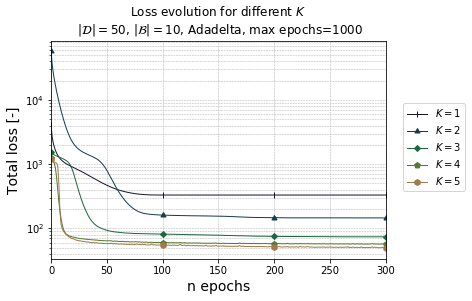

In [18]:
# Colors for plotting
color_map = plt.get_cmap('cubehelix')
colors = color_map(np.linspace(0.1, 1, 10))

# Initilize figure
comparison_K_fig = plt.figure()

# Plot SGD
i = 0
for model in models[:]:  
    n_epoch = np.arange(np.shape(model.losses)[0])
    plt.semilogy(n_epoch, model.losses, color=colors[i], linewidth=1, linestyle="-", marker=(i+2, 0, 0), markevery=100, label = '$K= {0} $'.format(model.nb_layers))
    print("For K={0} final loss is {1}".format(model.nb_layers, model.losses[-1]))
    i += 1

# Additional settings
plt.legend(bbox_to_anchor=(1.05, 0.31), loc=3, borderaxespad=0.)
plt.xlabel('n epochs', fontsize=14)
plt.ylabel('Total loss [-]', fontsize=14)
plt.xlim([0, 300])
#plt.ylim([0, 800])
plt.title('Loss evolution for different $K$ \n $|\mathcal{D}|=50$, $|\mathcal{B}|=10$, Adadelta, max epochs=1000')
plt.grid(True, which = "both", linewidth = 0.5,  linestyle = "--")

comparison_K_fig.savefig('../report/figs/comparison_K.eps', bbox_inches='tight')
plt.draw()
plt.show()

# Test on a bigger grid

In [19]:
from nnpde.metrics import least_squares_loss as LSE

In [20]:
# Grid size NxN
N = 64

# Use sufficiently high number of iterations to get ground truth solution
k_ground_truth = 20000

# Initialize Laplace problem on Square geometry
problem = DirichletProblem(N=N, k_ground_truth=20000)
B_idx = problem.B_idx
B = problem.B
f = problem.f

# Obtain solutions
ground_truth = problem.ground_truth

# Set initial_u equal for Jacobi method and for H method
initial_u = torch.ones(1,1,N,N)
k = 2000

# Obtain solution with Jacobi method
u_jacobi = im.jacobi_method(B_idx, B, f, initial_u, k = 2000)
print(f"Error after {k} iterations for Jacobi method: {LSE(ground_truth, u_jacobi)}")

# For each K obtain 
for model in models:
    u_H = im.H_method(model.net, B_idx, B, f, initial_u, k = 2000)
    print(f"Error after {k} iterations for H method with K={model.nb_layers}: {LSE(ground_truth, u_H)}")

Error after 2000 iterations for Jacobi method: 33.64340591430664
Error after 2000 iterations for H method with K=1: 7.877284957658048e-08
Error after 2000 iterations for H method with K=2: 1.012134731581682e-07
Error after 2000 iterations for H method with K=3: 1.0014544926661983e-07
Error after 2000 iterations for H method with K=4: 1.0188784216325075e-07
Error after 2000 iterations for H method with K=5: 1.0089386393019595e-07


# Plot square

2018-12-20 21:27:59,098 - matplotlib.colorbar - DEBUG - colorbar - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fecf075c6d8>
2018-12-20 21:27:59,099 - matplotlib.colorbar - DEBUG - colorbar - Using auto colorbar locator on colorbar
2018-12-20 21:27:59,100 - matplotlib.colorbar - DEBUG - colorbar - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fecf075c6d8>
2018-12-20 21:27:59,100 - matplotlib.colorbar - DEBUG - colorbar - Setting pcolormesh
2018-12-20 21:27:59,104 - matplotlib.axes._base - DEBUG - _base - update_title_pos
2018-12-20 21:27:59,163 - matplotlib.axes._base - DEBUG - _base - update_title_pos
2018-12-20 21:27:59,189 - matplotlib.axes._base - DEBUG - _base - update_title_pos
2018-12-20 21:27:59,205 - matplotlib.axes._base - DEBUG - _base - update_title_pos
2018-12-20 21:27:59,251 - matplotlib.axes._base - DEBUG - _base - update_title_pos
2018-12-20 21:27:59,270 - matplotlib.axes._base - DEBUG - _base - update_title_pos
2018-12-20 21:27:59,2

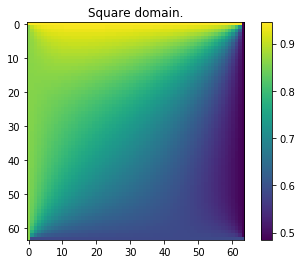

In [42]:
problem_square = DirichletProblem(N=N, k_ground_truth=20000)
ground_truth_square = problem_square.ground_truth.view(N, N).numpy()

square_fig = plt.figure()
im = plt.imshow(ground_truth_square)
plt.title("Square domain.")
plt.colorbar(im)

square_fig.savefig('../report/figs/square.eps', bbox_inches='tight')
plt.draw()
plt.show()

# Plot L shape

2018-12-20 21:28:41,364 - matplotlib.colorbar - DEBUG - colorbar - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fecf0534080>
2018-12-20 21:28:41,365 - matplotlib.colorbar - DEBUG - colorbar - Using auto colorbar locator on colorbar
2018-12-20 21:28:41,365 - matplotlib.colorbar - DEBUG - colorbar - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fecf0534080>
2018-12-20 21:28:41,366 - matplotlib.colorbar - DEBUG - colorbar - Setting pcolormesh
2018-12-20 21:28:41,370 - matplotlib.axes._base - DEBUG - _base - update_title_pos
2018-12-20 21:28:41,416 - matplotlib.axes._base - DEBUG - _base - update_title_pos
2018-12-20 21:28:41,445 - matplotlib.axes._base - DEBUG - _base - update_title_pos
2018-12-20 21:28:41,468 - matplotlib.axes._base - DEBUG - _base - update_title_pos
2018-12-20 21:28:41,515 - matplotlib.axes._base - DEBUG - _base - update_title_pos
2018-12-20 21:28:41,539 - matplotlib.axes._base - DEBUG - _base - update_title_pos
2018-12-20 21:28:41,5

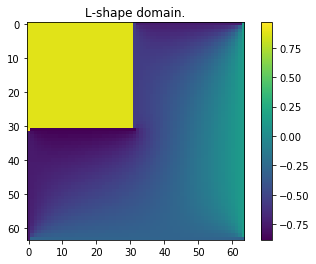

In [44]:
problem_l_shape = DirichletProblem(N=N, k_ground_truth=20000, domain_type = "l_shape")
ground_truth_l_shape = problem_l_shape.ground_truth.view(N, N).numpy()

square_fig = plt.figure()
im = plt.imshow(ground_truth_l_shape)
plt.title("L-shape domain.")
plt.colorbar(im)

square_fig.savefig('../report/figs/l_shape.eps', bbox_inches='tight')
plt.draw()
plt.show()

# Error evolution with iterations

In [21]:
tol = 1e-6
net = models[2].net

In [22]:
u_jacobi = initial_u
err_jacobi = LSE(ground_truth, u_jacobi).item()
errs_jacobi = [err_jacobi] 
k_jacobi = 0

while err_jacobi >= tol:
    u_jacobi = im.jacobi_method(B_idx, B, f, u_jacobi, k = 1)
    err_jacobi = LSE(ground_truth, u_jacobi).item()
    errs_jacobi.append(err_jacobi)
    k_jacobi += 1
    
print(f"Jacobi method: error of {tol} achieved after {k_jacobi} iterations.")

NameError: name 'err_to_be_achieved' is not defined

In [23]:
errors_H = []
max_iters = 10000

for model in models:
    u_H = initial_u
    err_H = LSE(ground_truth, u_H).item()
    errs_H = [err_H] 
    k_H = 0

    while err_H >= tol:
        u_H = im.H_method(model.net, B_idx, B, f, u_H, k = 1)
        err_H = LSE(ground_truth, u_H).item()
        errs_H.append(err_H)
        k_H += 1
        if k_H > max_iters or err_H == np.inf:
            print(f"H method, K = {model.nb_layers}: convergence not reached after {max_iters}, final error is {err_H}.")
            break
    
    print(f"H method, K = {model.nb_layers}: error of {tol} achieved after {k_H} iterations.")
    errors_H.append(errs_H)

H method, K = 1: error of 1e-06 achieved after 1863 iterations.
H method, K = 2: error of 1e-06 achieved after 840 iterations.
H method, K = 3: error of 1e-06 achieved after 486 iterations.
H method, K = 4: error of 1e-06 achieved after 379 iterations.
H method, K = 5: error of 1e-06 achieved after 312 iterations.


2018-12-20 20:53:44,524 - matplotlib.axes._base - DEBUG - _base - update_title_pos
2018-12-20 20:53:44,526 - matplotlib.ticker - DEBUG - ticker - vmin 0.6351622995324107 vmax 13785.452956584368
2018-12-20 20:53:44,527 - matplotlib.ticker - DEBUG - ticker - ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06])
2018-12-20 20:53:44,537 - matplotlib.ticker - DEBUG - ticker - vmin 0.6351622995324107 vmax 13785.452956584368
2018-12-20 20:53:44,538 - matplotlib.ticker - DEBUG - ticker - ticklocs [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 20000.0, 30000.0, 40000.0, 50000.0, 60000.0, 70000.0, 80000.0, 90000.0, 200000.0, 300000.0, 400000.0, 500000.0, 600000.0,

2018-12-20 20:53:45,080 - matplotlib.ticker - DEBUG - ticker - vmin 1e-06 vmax 7846.3623046875
2018-12-20 20:53:45,081 - matplotlib.ticker - DEBUG - ticker - ticklocs array([1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00,
       1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
2018-12-20 20:53:45,087 - matplotlib.ticker - DEBUG - ticker - vmin 1e-06 vmax 7846.3623046875
2018-12-20 20:53:45,088 - matplotlib.ticker - DEBUG - ticker - ticklocs [2e-07, 3e-07, 4e-07, 5e-07, 6e-07, 7e-07, 8e-07, 9e-07, 2e-06, 3e-06, 4e-06, 4.9999999999999996e-06, 6e-06, 7e-06, 8e-06, 9e-06, 2e-05, 3.0000000000000004e-05, 4e-05, 5e-05, 6.000000000000001e-05, 7.000000000000001e-05, 8e-05, 9e-05, 0.0002, 0.00030000000000000003, 0.0004, 0.0005, 0.0006000000000000001, 0.0007, 0.0008, 0.0009000000000000001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.

2018-12-20 20:53:45,302 - matplotlib.ticker - DEBUG - ticker - vmin 1e-06 vmax 7846.3623046875
2018-12-20 20:53:45,302 - matplotlib.ticker - DEBUG - ticker - ticklocs array([1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00,
       1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
2018-12-20 20:53:45,305 - matplotlib.ticker - DEBUG - ticker - vmin 1e-06 vmax 7846.3623046875
2018-12-20 20:53:45,314 - matplotlib.ticker - DEBUG - ticker - ticklocs [2e-07, 3e-07, 4e-07, 5e-07, 6e-07, 7e-07, 8e-07, 9e-07, 2e-06, 3e-06, 4e-06, 4.9999999999999996e-06, 6e-06, 7e-06, 8e-06, 9e-06, 2e-05, 3.0000000000000004e-05, 4e-05, 5e-05, 6.000000000000001e-05, 7.000000000000001e-05, 8e-05, 9e-05, 0.0002, 0.00030000000000000003, 0.0004, 0.0005, 0.0006000000000000001, 0.0007, 0.0008, 0.0009000000000000001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.

2018-12-20 20:53:45,473 - matplotlib.ticker - DEBUG - ticker - vmin 0.6351622995324107 vmax 13785.452956584368
2018-12-20 20:53:45,474 - matplotlib.ticker - DEBUG - ticker - ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06])
2018-12-20 20:53:45,477 - matplotlib.ticker - DEBUG - ticker - vmin 0.6351622995324107 vmax 13785.452956584368
2018-12-20 20:53:45,478 - matplotlib.ticker - DEBUG - ticker - ticklocs [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 20000.0, 30000.0, 40000.0, 50000.0, 60000.0, 70000.0, 80000.0, 90000.0, 200000.0, 300000.0, 400000.0, 500000.0, 600000.0, 700000.0, 800000.0, 900000.0, 2000000.0, 3000000.0, 4000000.0, 5000000.0, 6000000.

2018-12-20 20:53:45,985 - matplotlib.axes._base - DEBUG - _base - update_title_pos
2018-12-20 20:53:45,987 - matplotlib.ticker - DEBUG - ticker - vmin 0.6351622995324107 vmax 13785.452956584368
2018-12-20 20:53:45,988 - matplotlib.ticker - DEBUG - ticker - ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06])
2018-12-20 20:53:45,992 - matplotlib.ticker - DEBUG - ticker - vmin 0.6351622995324107 vmax 13785.452956584368
2018-12-20 20:53:45,993 - matplotlib.ticker - DEBUG - ticker - ticklocs [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 20000.0, 30000.0, 40000.0, 50000.0, 60000.0, 70000.0, 80000.0, 90000.0, 200000.0, 300000.0, 400000.0, 500000.0, 600000.0,

2018-12-20 20:53:46,558 - matplotlib.ticker - DEBUG - ticker - vmin 1e-06 vmax 7846.3623046875
2018-12-20 20:53:46,559 - matplotlib.ticker - DEBUG - ticker - ticklocs array([1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00,
       1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
2018-12-20 20:53:46,561 - matplotlib.ticker - DEBUG - ticker - vmin 1e-06 vmax 7846.3623046875
2018-12-20 20:53:46,562 - matplotlib.ticker - DEBUG - ticker - ticklocs [2e-07, 3e-07, 4e-07, 5e-07, 6e-07, 7e-07, 8e-07, 9e-07, 2e-06, 3e-06, 4e-06, 4.9999999999999996e-06, 6e-06, 7e-06, 8e-06, 9e-06, 2e-05, 3.0000000000000004e-05, 4e-05, 5e-05, 6.000000000000001e-05, 7.000000000000001e-05, 8e-05, 9e-05, 0.0002, 0.00030000000000000003, 0.0004, 0.0005, 0.0006000000000000001, 0.0007, 0.0008, 0.0009000000000000001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.

2018-12-20 20:53:46,779 - matplotlib.ticker - DEBUG - ticker - vmin 1e-06 vmax 7846.3623046875
2018-12-20 20:53:46,779 - matplotlib.ticker - DEBUG - ticker - ticklocs array([1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00,
       1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
2018-12-20 20:53:46,782 - matplotlib.ticker - DEBUG - ticker - vmin 1e-06 vmax 7846.3623046875
2018-12-20 20:53:46,783 - matplotlib.ticker - DEBUG - ticker - ticklocs [2e-07, 3e-07, 4e-07, 5e-07, 6e-07, 7e-07, 8e-07, 9e-07, 2e-06, 3e-06, 4e-06, 4.9999999999999996e-06, 6e-06, 7e-06, 8e-06, 9e-06, 2e-05, 3.0000000000000004e-05, 4e-05, 5e-05, 6.000000000000001e-05, 7.000000000000001e-05, 8e-05, 9e-05, 0.0002, 0.00030000000000000003, 0.0004, 0.0005, 0.0006000000000000001, 0.0007, 0.0008, 0.0009000000000000001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.

2018-12-20 20:53:46,992 - matplotlib.ticker - DEBUG - ticker - vmin 0.6351622995324107 vmax 13785.452956584368
2018-12-20 20:53:46,994 - matplotlib.ticker - DEBUG - ticker - ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06])
2018-12-20 20:53:46,997 - matplotlib.ticker - DEBUG - ticker - vmin 0.6351622995324107 vmax 13785.452956584368
2018-12-20 20:53:46,998 - matplotlib.ticker - DEBUG - ticker - ticklocs [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 20000.0, 30000.0, 40000.0, 50000.0, 60000.0, 70000.0, 80000.0, 90000.0, 200000.0, 300000.0, 400000.0, 500000.0, 600000.0, 700000.0, 800000.0, 900000.0, 2000000.0, 3000000.0, 4000000.0, 5000000.0, 6000000.

2018-12-20 20:53:47,134 - matplotlib.ticker - DEBUG - ticker - ticklocs [2e-07, 3e-07, 4e-07, 5e-07, 6e-07, 7e-07, 8e-07, 9e-07, 2e-06, 3e-06, 4e-06, 4.9999999999999996e-06, 6e-06, 7e-06, 8e-06, 9e-06, 2e-05, 3.0000000000000004e-05, 4e-05, 5e-05, 6.000000000000001e-05, 7.000000000000001e-05, 8e-05, 9e-05, 0.0002, 0.00030000000000000003, 0.0004, 0.0005, 0.0006000000000000001, 0.0007, 0.0008, 0.0009000000000000001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 20000.0, 30000.0, 40000.0, 50000.0, 60000.0, 70000.0, 80000.0, 90000.0, 200000.0, 300000.0, 400000.0, 500000.0, 600000.0, 700000.0, 800000.0, 900000.0]
2018-12-20 20:53:4

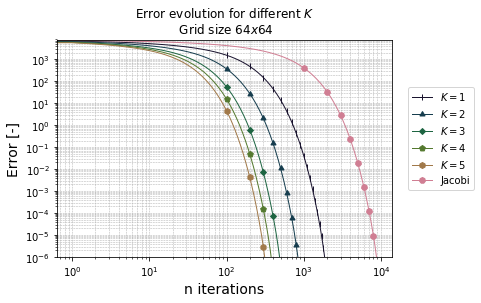

In [29]:
# Colors for plotting
color_map = plt.get_cmap('cubehelix')
colors = color_map(np.linspace(0.1, 1, 10))

# Initilize figure
error_k_fig = plt.figure()

i = 0
for error in errors_H:  
    n_iter = np.arange(np.shape(error)[0])
    plt.loglog(n_iter, error, color=colors[i], linewidth=1, linestyle="-", marker=(i+2, 0, 0), markevery=100, label = '$K= {0} $'.format(models[i].nb_layers))
    i += 1

# Plot error evolution for Jacobi 
n_iter = np.arange(np.shape(errs_jacobi)[0])
plt.loglog(n_iter, errs_jacobi, color=colors[i], linewidth=1, linestyle="-", marker=(i+2, 0, 0), markevery=1000, label = 'Jacobi')

# Additional settings
plt.legend(bbox_to_anchor=(1.05, 0.31), loc=3, borderaxespad=0.)
plt.xlabel('n iterations', fontsize=14)
plt.ylabel('Error [-]', fontsize=14)
#plt.xlim([0, max_epochs])
plt.ylim([tol, errors_H[0][0]])
plt.title('Error evolution for different $K$\n Grid size ${0}x{0}$'.format(N))
plt.grid(True, which = "both", linewidth = 0.5,  linestyle = "--")

error_k_fig.savefig('../report/figs/error_k.eps', bbox_inches='tight')
plt.draw()
plt.show()

In [ ]:
# This is not correct, but we have to look for a way to access the variables inside timeit

print("needed {0} iterations (compared to {1}), ratio: {2}".format(k_count_old, k_count_new, k_count_old/k_count_new))

In [ ]:
print("the loss of the new method is {0}, compared to the pure-jacoby one: {1}. computed with {2} iterations".format(F.mse_loss(gtt, output), F.mse_loss(gtt, jacoby_pure), nb_iters))

In [ ]:
helpers.plot_solution(gtt,output,N)

In [ ]:
(gtt.view(N,N) - output.view(N,N)).mean()

Test on L-shape domain

In [ ]:
B_idx, B = geometries.l_shaped_geometry(N)

# Set forcing term
f = torch.ones(1,1,N,N)*1.0

# Obtain solutions
gtt = im.jacobi_method(B_idx, B, f, torch.ones(1,1,N,N), k = 10000)
output = im.H_method(net, B_idx, B, f, torch.ones(1,1,N,N), k = 2000)

In [ ]:
helpers.plot_solution(gtt,output,N)

In [ ]:
compare_flops(16,k_count_new,k_count_old,3)

In [ ]:
Spectral radius. Don't remove Francesco will delete me

In [ ]:
B_idx = problem_instances[1].B_idx
net = nn.Sequential(nn.Conv2d(1, 1, 3, padding=1, bias=False))
G = helpers.build_G(B_idx)
T = helpers.build_T(N)
H = helpers.conv_net_to_matrix(net, N)
I = np.eye(N)
helpers.spectral_radius(T+G.dot(H).dot(T)-G.dot(H))

# Model testing

In [ ]:
import nnpde.model_testing as MT
import nnpde.problems as PDEF
reload(MT)
reload(PDEF)

In [ ]:
tol = 1e-6
base_parameters

In [ ]:
mdl = M.JacobyWithConv(**{**base_parameters, **{'max_epochs': 500, 'optimizer': 'Adadelta', 'nb_layers': 4}}).fit(problem_instances)

In [ ]:
tests_n10_g32 = MT.test_results_pd(mdl, 4, 32, tol=1e-6, convergence_tol = 1e-12)
tests_n10_g32.to_pickle('./data/grid_32.pkl')

In [ ]:
tests_n10_g32

In [ ]:
# takes 7m!
test_results = MT.test_results_pd(mdl, 5, 64, tol=tol, convergence_tol=1e-12)
test_results.to_pickle('./data/grid_64.pkl')
test_results

In [ ]:
test_results2 = MT.test_results_pd(mdl.net, 100, 256, tol=tol)
test_results2.to_pickle('./data/grid_256.pkl')
test_results2

In [ ]:
test_results3 = MT.test_results_pd(mdl.net, 100, 512, tol=tol)
test_results3.to_pickle('./data/grid_512.pkl')
test_results3

In [ ]:
test_results_big_dimension = MT.test_results_pd(mdl.net, 10, 256)
4
test_results_big_dimension

In [ ]:
test_results_ada = MT.test_results_pd(mdlAda.net, 1, 64)
test_results_ada

In [ ]:
test_results_ada = MT.test_results_pd(mdlAda.net, 10, 64)
test_results_ada_big_dimension = MT.test_results_pd(mdl.netAda, 10, 256)